# Vision Transformer (ViT)

## Dataset

In [25]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

from tiny_imagenet import TinyImageNet

device  = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATASET = "MNIST"
BS = 32

if DATASET == "MNIST":
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BS, shuffle=True)
    train_image_zero, train_target_zero = trainset[0]

elif DATASET == "CIFAR10":
    stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]
elif DATASET == "TINY_IMAGENET":
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(), 
        transforms.RandomCrop(64, padding=4, padding_mode='reflect'), 
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats, inplace=True)
    ])

    trainset = TinyImageNet(root='./data', split="train",  download=True, transform=train_transform)
    testset =  TinyImageNet(root='./data', split="val", download=True, transform=test_transform)

    trainloader = torch.utils.data.DataLoader(
        trainset,
        batch_size=BS,
        shuffle=True,
        num_workers=3,
        pin_memory=True)
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=BS * 2,
        shuffle=False,
        num_workers=3,
        pin_memory=True)
    
    train_image_zero, train_target_zero = trainset[0]

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

# trainloader.to(device)
# testloader.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


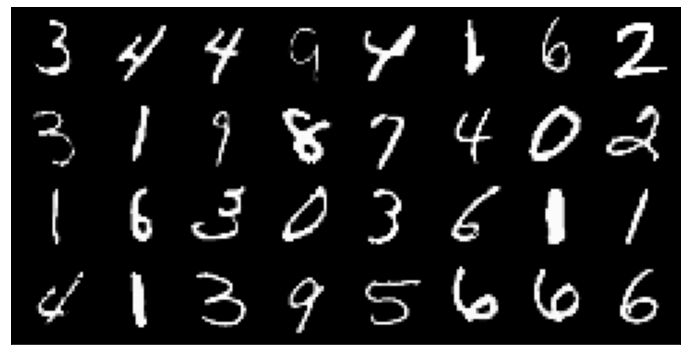

In [26]:
show_batch(trainloader)

## Model

### Model Arch

In [82]:
import torch
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F

def patchify(images, patch_size):
    # B, C, W, H -> B, C * P_W * P_H
    assert len(images.shape) == 4, "Input tensor must have shape (B, C, H, W)"
    B, C, H, W = images.shape
    assert H % patch_size == 0, "Image height must be divisible by patch size"
    assert W % patch_size == 0, "Image width must be divisible by patch size"
    patches = rearrange(
        images,
        "b c (w p1) (h p2) -> b (w h) (p1 p2 c)",
        p1=patch_size,
        p2=patch_size)
    return patches

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout):
        super(Attention, self).__init__()
        inner_dim = dim_head * heads
        proj_out  = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend  = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if proj_out else nn.Identity()
    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super(TransformerEncoder, self).__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, MLP(dim, mlp_dim, dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x
    
class ViT(nn.Module):
    def __init__(
            self,
            patch_emb,
            num_patches,
            n_classes,
            heads=1,
            dim=128,
            dim_head=16,
            emb_dropout=0.,
            depth=1,
            mlp_dim=512,
            debug=False):
        super(ViT, self).__init__()
        
        self.patch_fc    = nn.Linear(patch_emb, dim)
        self.pos_emb     = nn.Parameter(torch.randn(1, num_patches+1, dim))
        self.cls_token   = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer = TransformerEncoder(
            dim, depth, heads, dim_head, mlp_dim)

        # self.to_latent   = nn.Identity()

        self.mlp_head    = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_classes))
        
    def forward(self, x, debug=False):
        # learned patch embedding
        x = self.patch_fc(x)
        b, n, _ = x.shape
        
        # class token + pos embed
        cls_tokens = repeat(self.cls_token, "1 1 d -> b 1 d", b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        if debug: print("x.shape, self.pos_emb.shape:", x.shape, self.pos_emb.shape)
        x = x + self.pos_emb[:, :(n+1)]
        x = self.emb_dropout(x)

        # transformer
        x = self.transformer(x)
        
        # cls token (can also use mean pooling)
        x = x[:, 0]

        # mlp classifier
        x = self.mlp_head(x)

        return x
    
    def get_params(self):
        o = [param.numel() for param in self.parameters() if param.requires_grad]
        o = sum(o)
        return o

In [85]:
IMG_SIZE    = 28
CHANNELS    = 1
N_CLASSES   = 10
PATCH_SIZE  = 14 # 28 // 4
DEBUG       = False
PATCH_EMB   = PATCH_SIZE ** 2 * CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
N_BLOCKS    = 1

model = ViT(
    patch_emb=PATCH_EMB,
    n_classes=N_CLASSES,
    num_patches=NUM_PATCHES,
    depth=N_BLOCKS,
    debug=DEBUG).to(device)

test_inp = torch.randint(0, 1, size=(1, CHANNELS, IMG_SIZE, IMG_SIZE)).float().to(device)
test_inp = patchify(test_inp, PATCH_SIZE)
print(test_inp.shape)
pred = model(test_inp, debug=True)
pred.shape, model.get_params()

torch.Size([1, 4, 196])
x.shape, self.pos_emb.shape: torch.Size([1, 5, 128]) torch.Size([1, 5, 128])


(torch.Size([1, 10]), 168074)